# Data Scientist Challenge - A3Data
Solved by Jéssica Ferreira Soares

**Index**
- [1) Import libraries](#libraries)
- [2) Read dataset](#read-dataset)
- [3) Challenge questions](#challenge-questions)
    - [3.1) Question 1](#question1)
    - [3.1) Question 2](#question2)
    - [3.1) Question 3](#question3)
    - [3.1) Question 4](#question4)
    - [3.1) Question 5](#question5)

## 1) Import libraries <a class="anchor" id="libraries"></a>

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from datetime import datetime
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

## 2) Read dataset <a class="anchor" id="read-dataset"></a>

In [28]:
df = pd.read_csv("dataset/Customer-Churn - Customer-Churn.csv")

In [29]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


In [30]:
def calculate_missing_values(df):
    '''Receive a dataframe and calculate the percentage of missing values'''

    # Step 1: Calculate the total number of missing values per column
    missing_values = df.isnull().sum()

    # Step 2: Calculate the total number of rows in the DataFrame
    total_rows = df.shape[0]

    # Step 3: Calculate the percentage of missing values per column
    percentage_missing = (missing_values / total_rows) * 100

    # Step 4: Create a new DataFrame to display the results
    result_df = pd.DataFrame({
        'Column': missing_values.index,
        'Percentage Missing': percentage_missing
    })

    # Step 5: Print the result DataFrame
    print(result_df)

#_______________________________________________________________________________________

def plot_bar_categorical_features(df,column_name):
    '''Plot bar plot of categorical feature using percetange in the Y axis
    given the dataframe df and the column_name'''

    available_status = df[column_name].value_counts()
    plt.figure(figsize=(10,6))
    (available_status/df.shape[0]).plot(kind="bar");
    plt.title("Perc distribution - "+column_name);
    plt.show()


## 3) Exploratory data analysis <a class="anchor" id="challenge-questions"></a>

### 3.1) How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this? <a class="anchor" id="question1"></a>

**Answer:**
- The busiest months of the year are January/February and December;
- The end of the month are the busiest period of the month;
- The following columns have all the same registers for every row:
    - AÑO (Year of flight operation.): 2017
    - SIGLAORI (Name city of origin.): Santiago
    - Ori-O (Operation origin city code): SCEL
- There are more national flights than international, however the distribution is very similar;
- Grupo Latam airlines operates around 60% of the flights
- There were 0.15% of the flights that had different flight scheduled number from operation flight number;
- The airline code (Emp-I) correspond to airline name (OPERA);
- The columns Ori-I (Programmed origin city code.) and Ori-O (Operation origin city code) are the same; It means that the flight plans towards the city did not change but related to the flight can change;
- About the weekdays:
    - Friday is the busiest weekday;
    - Friday, Thursday, Monday have very similar flight numbers;
    - Sunday, Wednesdays, Tuesday have very similar flight numbers;
    - Saturday is the less busy day; 
- Columns that I can drop before training a model: AÑO, SIGLAORI, Ori-O, Ori-I, Emp-I.

**Analysis ideas ideas**
- Check distribution of national and international flights
- Check if there is a python library for destination city code for airports
- Check if national and international flights change accoridng the the weekday
- Check if flights distributed in days of the week change accoring to the months

**Check Nan values**

In [31]:
#Evaluate percentage of missing values
print("df.shape = ", df.shape)
calculate_missing_values(df)

df.shape =  (7043, 21)
                            Column  Percentage Missing
customerID              customerID            0.000000
gender                      gender            0.000000
SeniorCitizen        SeniorCitizen            0.000000
Partner                    Partner            0.000000
Dependents              Dependents            0.000000
tenure                      tenure            0.000000
PhoneService          PhoneService            0.000000
MultipleLines        MultipleLines            0.000000
InternetService    InternetService            0.000000
OnlineSecurity      OnlineSecurity            0.000000
OnlineBackup          OnlineBackup            0.000000
DeviceProtection  DeviceProtection            0.000000
TechSupport            TechSupport            0.000000
StreamingTV            StreamingTV            0.000000
StreamingMovies    StreamingMovies            0.000000
Contract                  Contract            0.000000
PaperlessBilling  PaperlessBilling        

In [32]:
#Drop rows with missing values
df.dropna(inplace=True)

#Verify dataframe after dropping rows with Nan values
print("df.shape = ", df.shape)
calculate_missing_values(df)

df.shape =  (7032, 21)
                            Column  Percentage Missing
customerID              customerID                 0.0
gender                      gender                 0.0
SeniorCitizen        SeniorCitizen                 0.0
Partner                    Partner                 0.0
Dependents              Dependents                 0.0
tenure                      tenure                 0.0
PhoneService          PhoneService                 0.0
MultipleLines        MultipleLines                 0.0
InternetService    InternetService                 0.0
OnlineSecurity      OnlineSecurity                 0.0
OnlineBackup          OnlineBackup                 0.0
DeviceProtection  DeviceProtection                 0.0
TechSupport            TechSupport                 0.0
StreamingTV            StreamingTV                 0.0
StreamingMovies    StreamingMovies                 0.0
Contract                  Contract                 0.0
PaperlessBilling  PaperlessBilling        

**Evaluate numerical features**

In [33]:
#Convert Vlo-O and Vlo-I to int type - Part 1

# Step 1: Use pd.to_numeric() to convert the column to numeric type
#df['Vlo-O'] = pd.to_numeric(df['Vlo-O'], errors='coerce')
#df['Vlo-I'] = pd.to_numeric(df['Vlo-I'], errors='coerce')

#calculate_missing_values(df)

In [34]:
#Convert Vlo-O and Vlo-I to int type - Part 2

#Drop rows with missing values
#df.dropna(inplace=True)

#Verify dataframe after dropping rows with Nan values
#print("df.shape = ", df.shape)
#calculate_missing_values(df)

# Step 2: Use astype() to convert the column to integer type
#df['Vlo-O'] = df['Vlo-O'].astype(int)
#df['Vlo-I'] = df['Vlo-I'].astype(int)

In [35]:
#print(df.dtypes)

In [36]:
df.dtypes

customerID          object
gender              object
SeniorCitizen        int64
Partner             object
Dependents          object
tenure               int64
PhoneService        object
MultipleLines       object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
MonthlyCharges      object
TotalCharges        object
Churn               object
dtype: object

In [37]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


In [38]:
def fix_float_cols(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: float(x.replace(",", ".")))
fix_columns_float = ['MonthlyCharges', 'TotalCharges']
for col in fix_columns_float:
    fix_float_cols(df,col)
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>,
        <Axes: title={'center': 'TotalCharges'}>]], dtype=object)

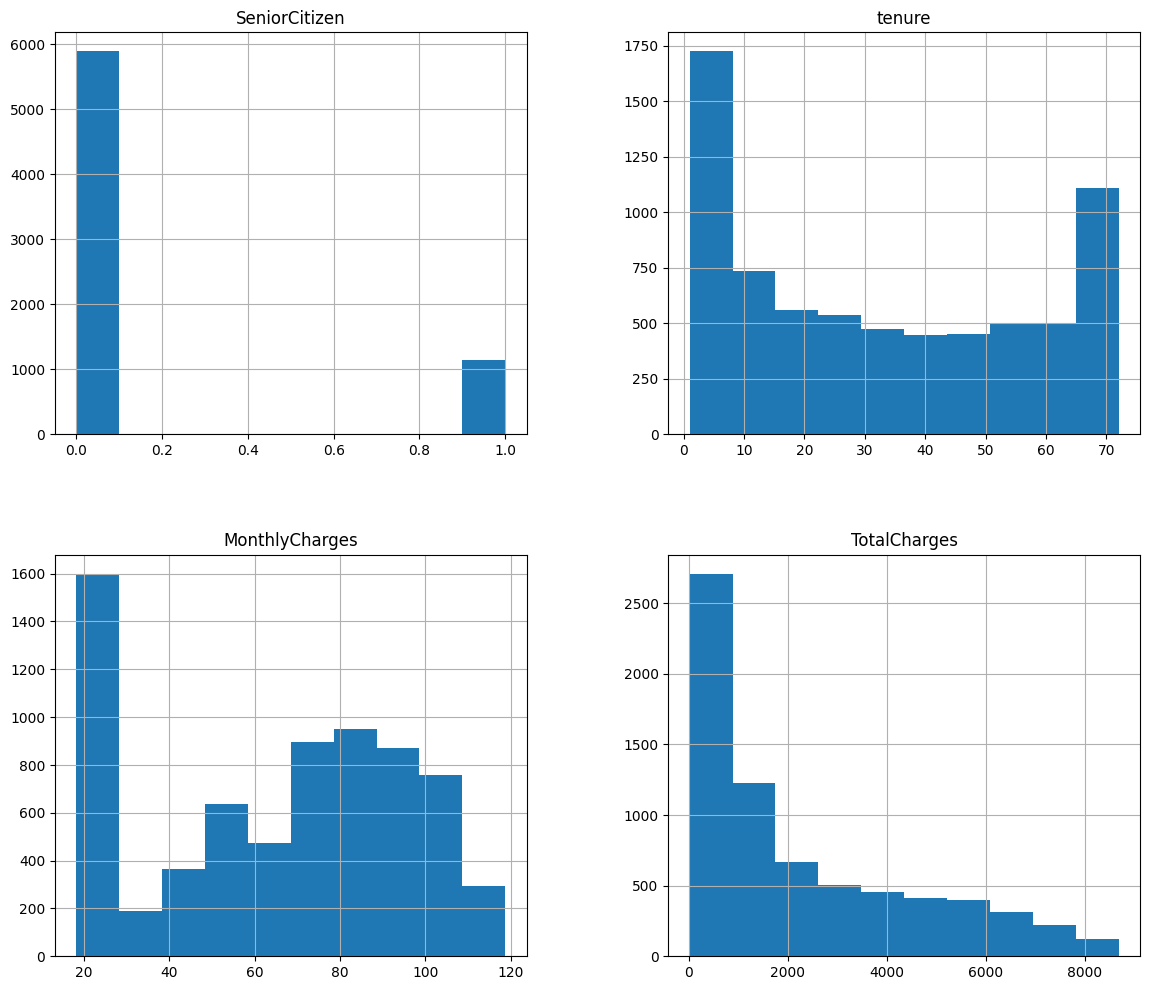

In [39]:
df.hist(figsize = (14,12))

In [11]:
# The distribution of Vlo-O and Vlo-I look the same. Are these two columns equal?
#df['Vlo-O'].equals(df['Vlo-I']) 

In [12]:
# Are the columns Ori-I and Ori-O equal?
#df['Ori-I'].equals(df['Ori-O']) 

In [13]:
# Are the columns Des-I and Des-O equal?
#df['Des-I'].equals(df['Des-O'])

In [14]:
# Are the columns Emp-I and Emp-O equal?
#['Emp-I'].equals(df['Emp-O'])

In [15]:
# using Counter to find frequency of elements
#frequency = collections.Counter(list(df['Vlo-O']==df['Vlo-I']))

# printing the frequency
#print(dict(frequency))

In [16]:
#print("Pencentage of the flights that had different scheduled number from operation number = ", 100/len(list(df['Vlo-O']==df['Vlo-I']))*100)

**Evaluate categorical features**

In [17]:
#df.columns

Contract


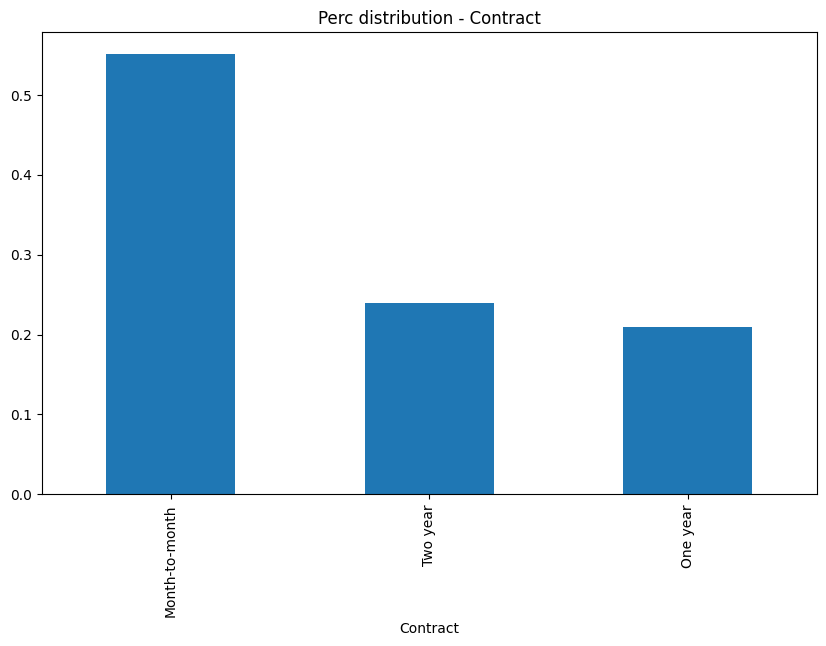

MultipleLines


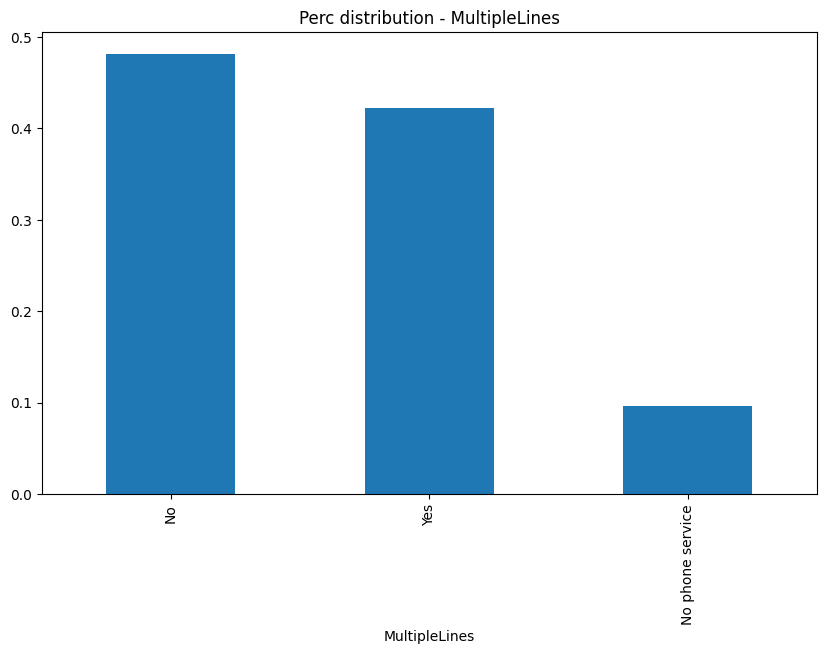

StreamingTV


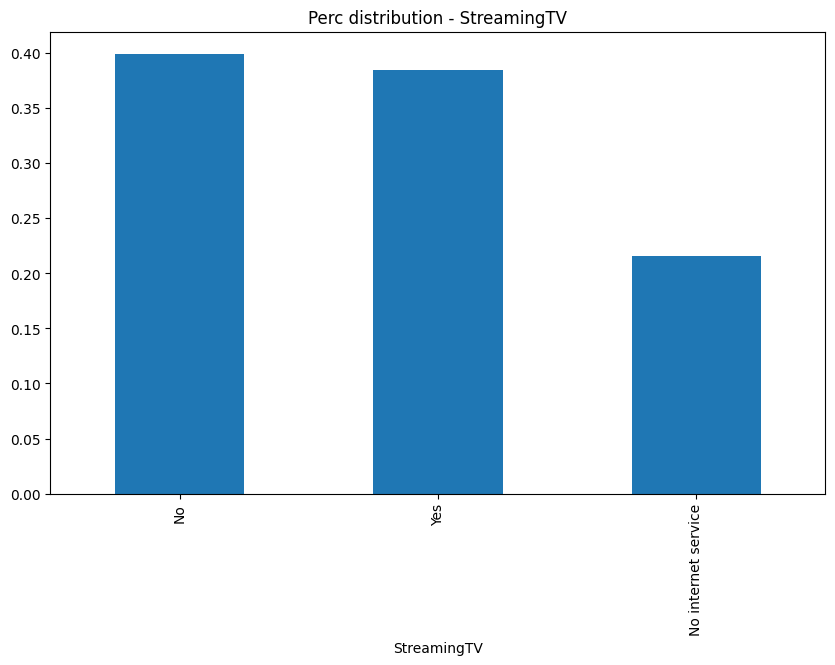

PhoneService


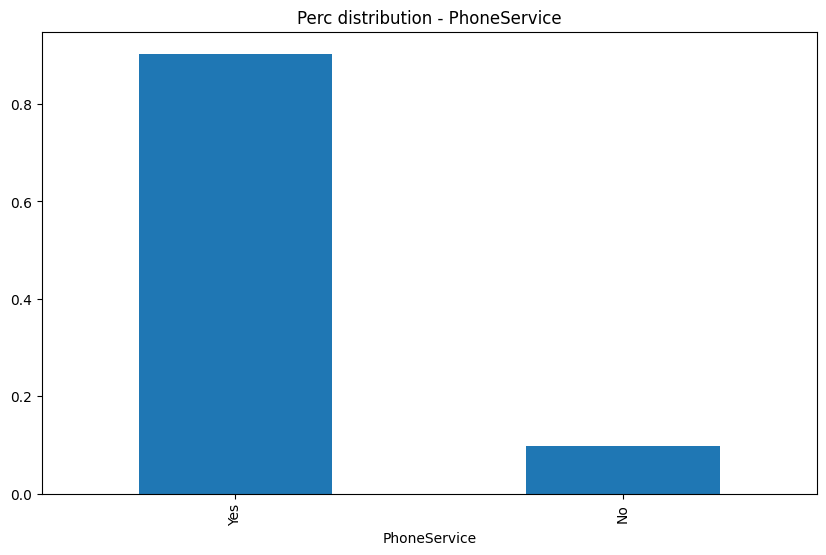

Partner


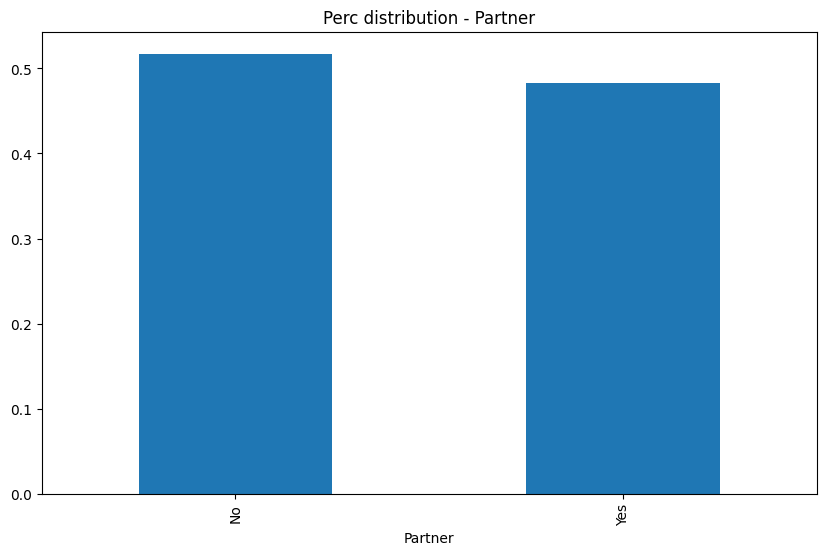

OnlineBackup


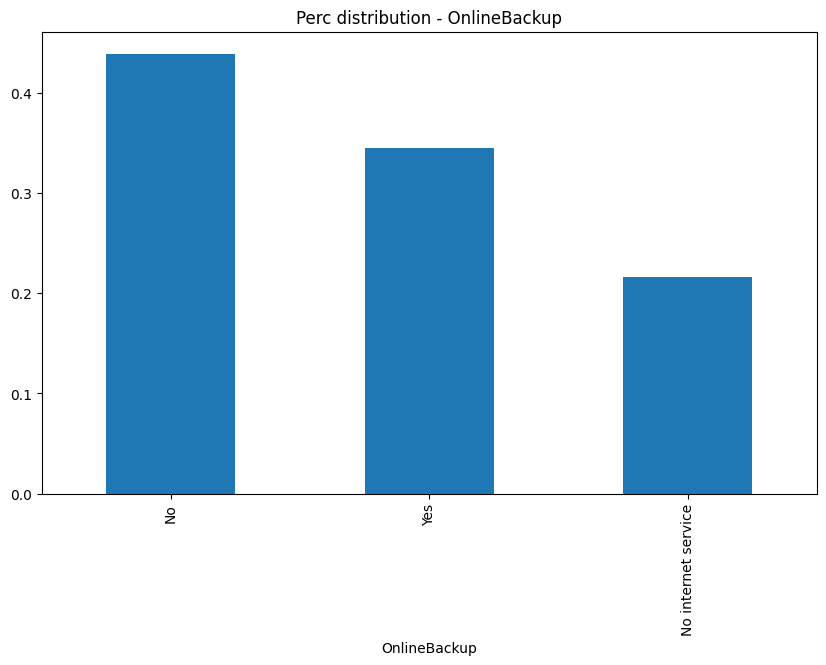

Dependents


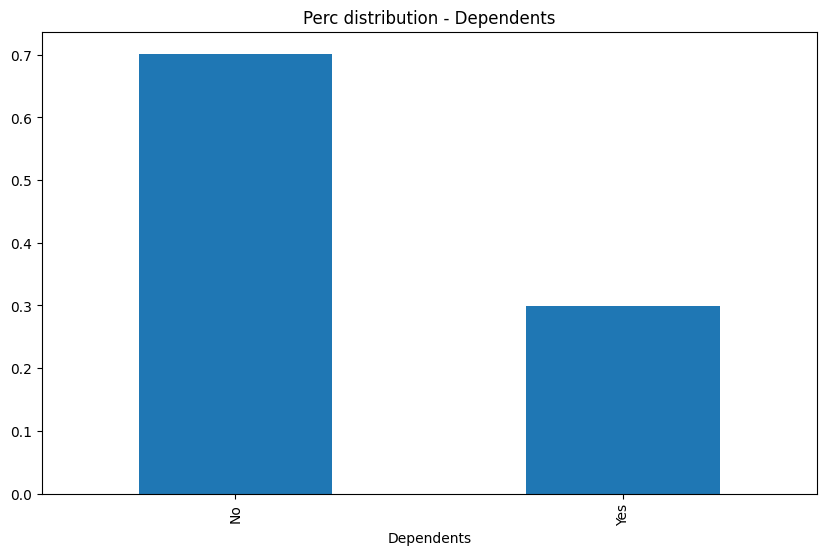

TechSupport


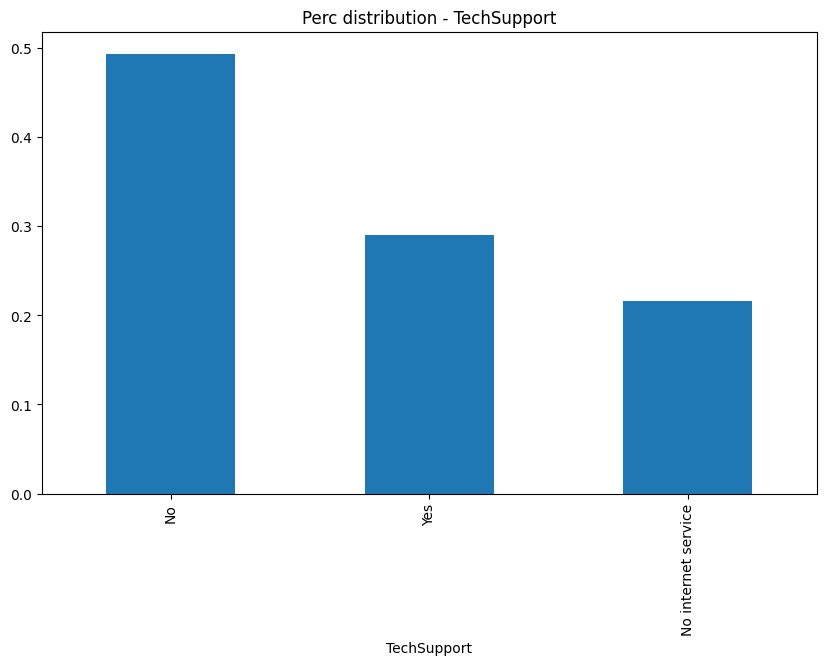

gender


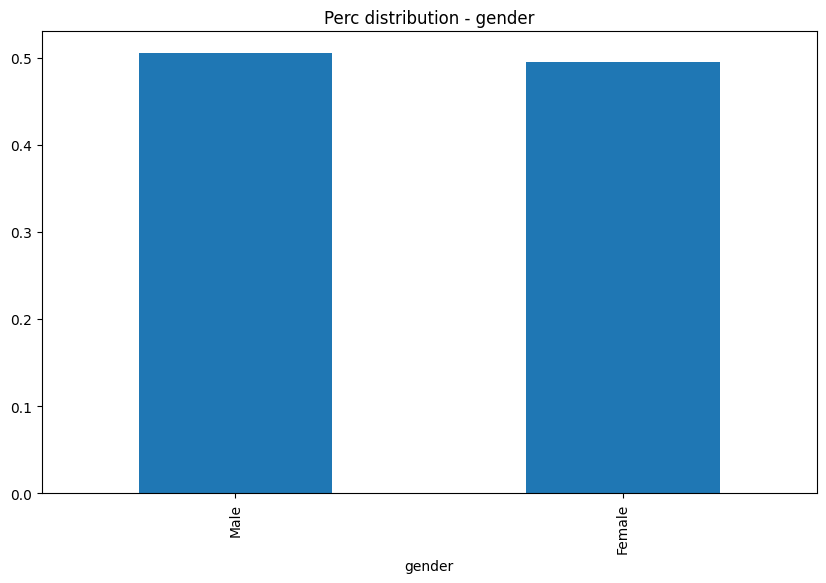

Churn


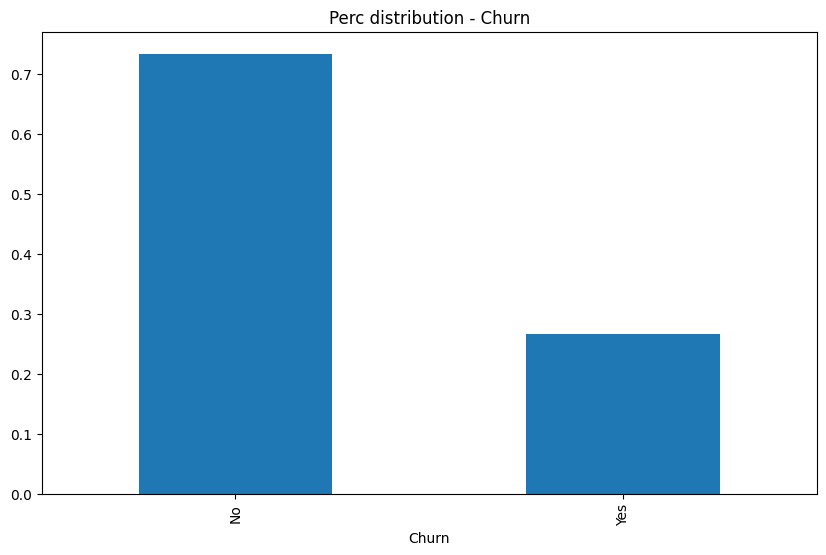

DeviceProtection


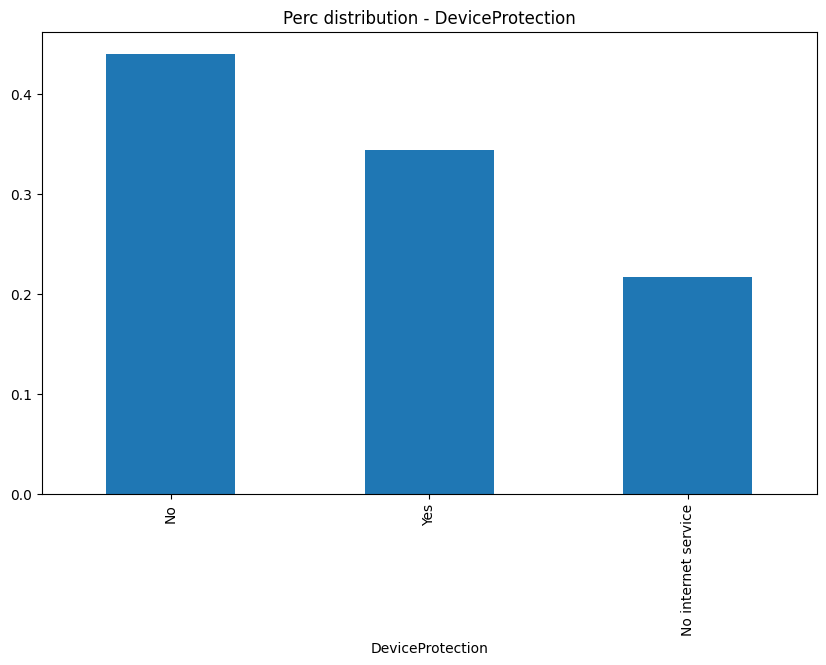

PaperlessBilling


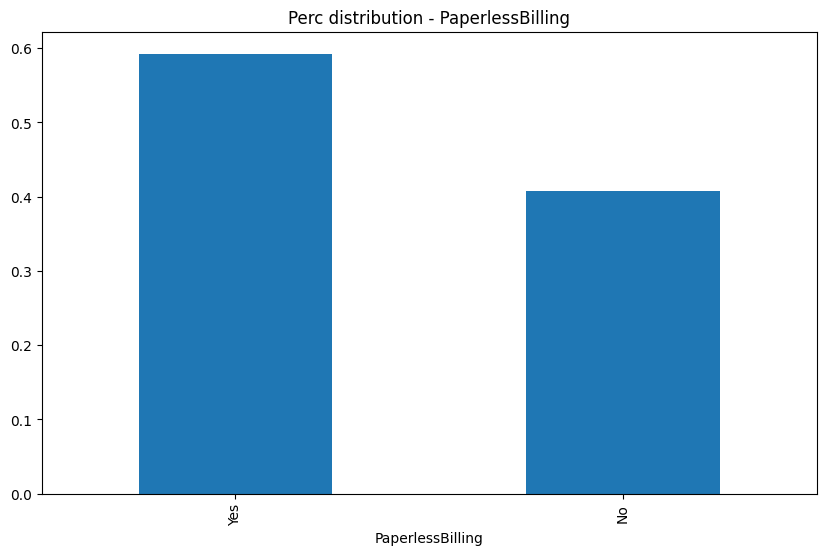

SeniorCitizen


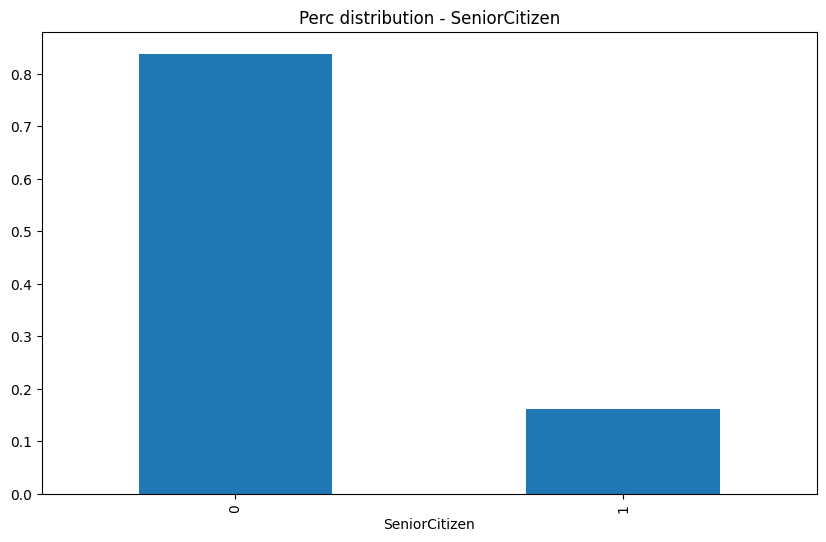

InternetService


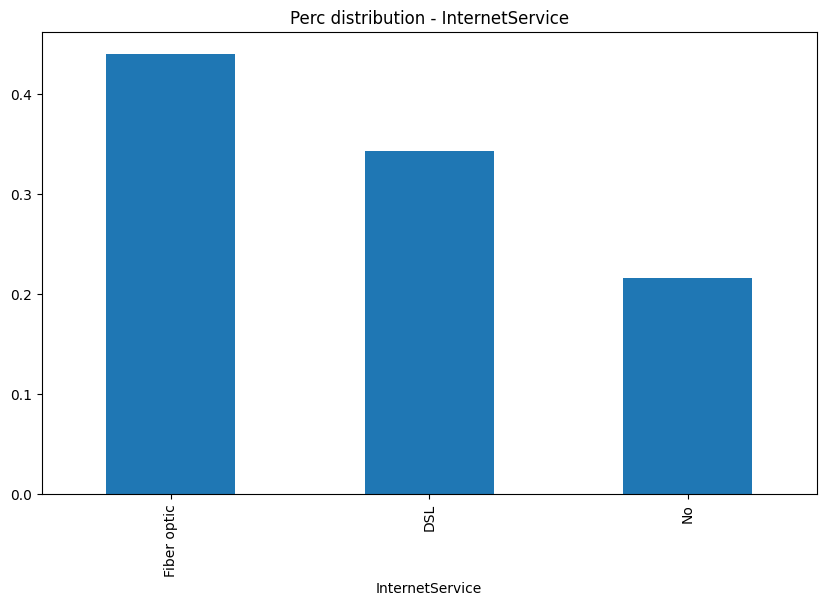

OnlineSecurity


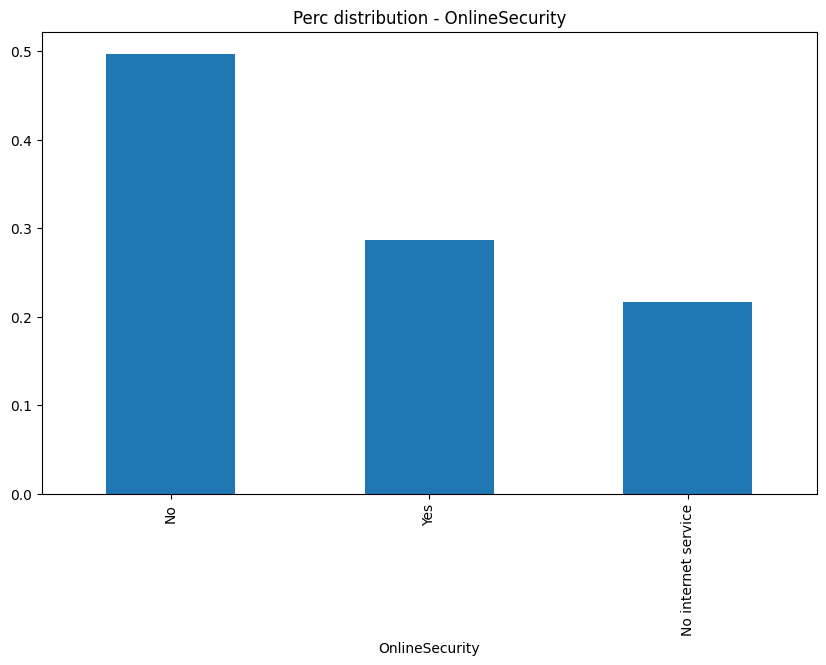

PaymentMethod


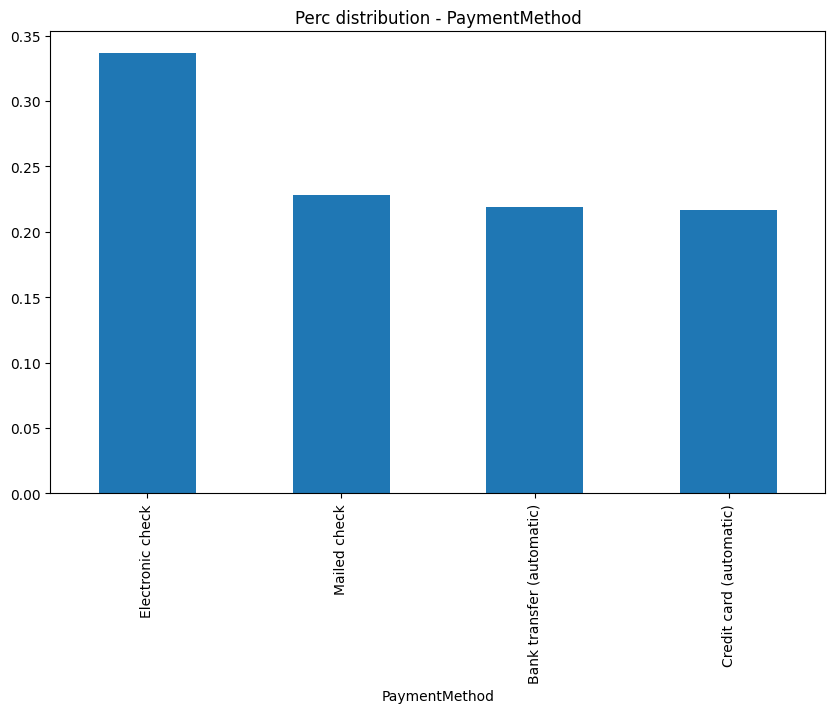

StreamingMovies


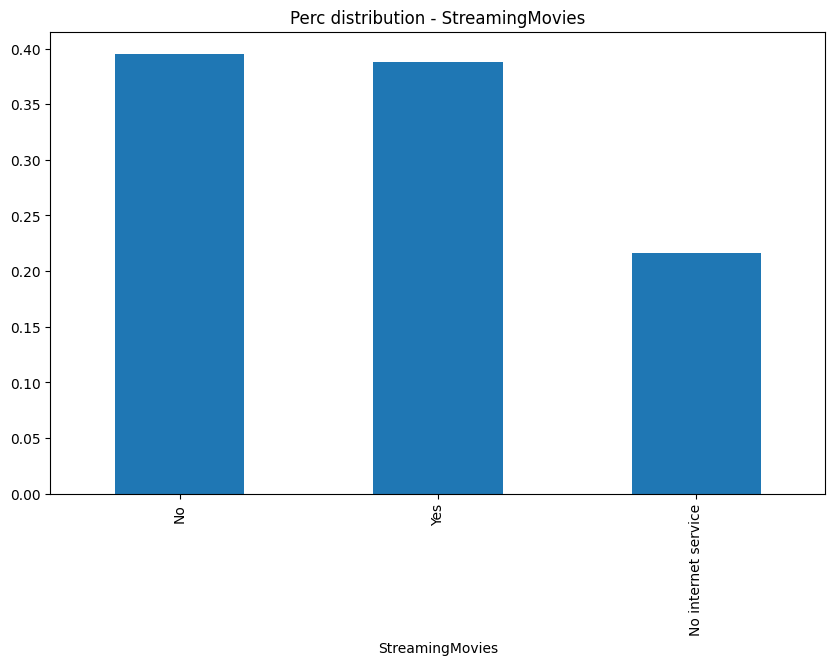

In [40]:
#Plot categorical features
additional_features = ['SeniorCitizen']
remove_features = ['customerID']
categorical_features = list(df.select_dtypes(include=["object"]).columns)
categorical_features = categorical_features + additional_features
categorical_features = list(set(categorical_features) - set(remove_features))

for col in categorical_features:
    print(col)
    plot_bar_categorical_features(df, col)

### 3.2) Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv: <a class="anchor" id="question2"></a>
- high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
- min_diff : difference in minutes between Date-O and Date-I .
- delay_15 : 1 if min_diff > 15, 0 if not.
- period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I .

**Answer:**
- The csv file with the new features were saved inside the folder dataset in this repo

In [19]:
# Convert columns with date information to date type

#Fecha-I: Scheduled date and time of the flight.
#Fecha-O : Date and time of flight operation.
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])

In [20]:
def check_date_between_period(date, start_date, end_date):
    '''Given an hour of the day, this function returns the period of the day'''

    # Define datetime format
    datetime_format = '%Y-%m-%d %H:%M:%S'
    # Define the two times for comparison
    start_date = datetime.strptime(start_date, datetime_format)
    end_date = datetime.strptime(end_date, datetime_format)
    # Check if the data variable is between the start_time and end_time
    is_between_times = start_date <= date <= end_date

    return is_between_times

def categorize_high_season(date):
    '''Given an hour of the day, this function returns the period of the day'''
    
    if check_date_between_period(date, '2017-12-15 00:00:00', '2017-12-31 23:59:59'):
        return 1
    elif check_date_between_period(date, '2017-01-01 00:00:00', '2017-03-03 23:59:59'):
        return 1
    elif check_date_between_period(date, '2017-07-15 00:00:00', '2017-07-31 23:59:59'):
        return 1
    elif check_date_between_period(date, '2017-09-11 00:00:00','2017-09-30 23:59:59'):
        return 1
    else:
        return 0



In [21]:
# Calculate high_season
df['high_season'] = df['Fecha-I'].apply(categorize_high_season)
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,1
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,1
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,1
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,1


In [22]:
def check_time_between_period(date, start_time, end_time):
    '''Given an hour of the day, this function returns the period of the day'''

    # Define datetime format
    datetime_format = '%Y-%m-%d %H:%M:%S'
    # Define the two times for comparison
    start_time = datetime.strptime(date.strftime('%Y-%m-%d')+' '+start_time, datetime_format)
    end_time = datetime.strptime(date.strftime('%Y-%m-%d')+' '+end_time, datetime_format)
    
    # Check if the data variable is between the start_time and end_time
    is_between_times = start_time <= date <= end_time

    return is_between_times

def categorize_period_day(date):
    '''Given an hour of the day, this function returns the period of the day'''
    
    if check_time_between_period(date, '05:00:00', '11:59:00'): 
        return 'morning'
    elif check_time_between_period(date, '12:00:00', '18:59:00'):
        return 'afternoon'
    elif check_time_between_period(date, '19:00:00', '23:59:00') or check_time_between_period(date, '00:00:00', '04:59:00'):
        return 'night'
    else:
        return 'whatever'
    

#print(categorize_period_day(df['Fecha-I'][1549]))
#print(categorize_period_day(df['Fecha-I'][4549]))
#print(categorize_period_day(df['Fecha-I'][7790]))
#print(categorize_period_day(df['Fecha-I'][0]))

In [23]:
#Calculate min_diff
df['min_diff'] = (df['Fecha-O'] - df['Fecha-I']).dt.total_seconds() / 60
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0


In [24]:
#Calculate delay_15
df['delay_15'] = df['min_diff'].apply(lambda x: 1 if x>15 else 0)
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,1,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0


In [25]:
# Calculate period_day
df['period_day'] = df['Fecha-I'].apply(categorize_period_day)
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0,night


In [26]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'high_season', 'min_diff', 'delay_15',
       'period_day'],
      dtype='object')

In [27]:
#Save updated dataframe with new features as a csv
df.to_csv("dataset/synthetic_features.csv", index=False)

**Visualization of new features**

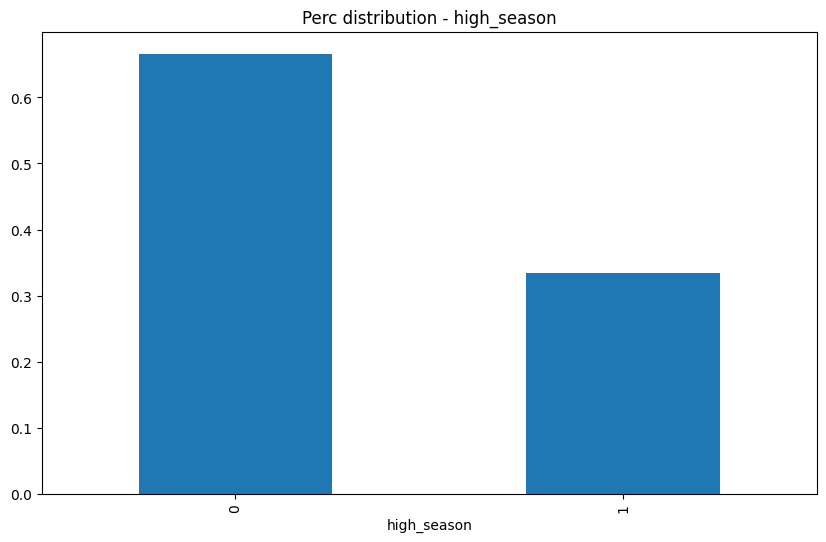

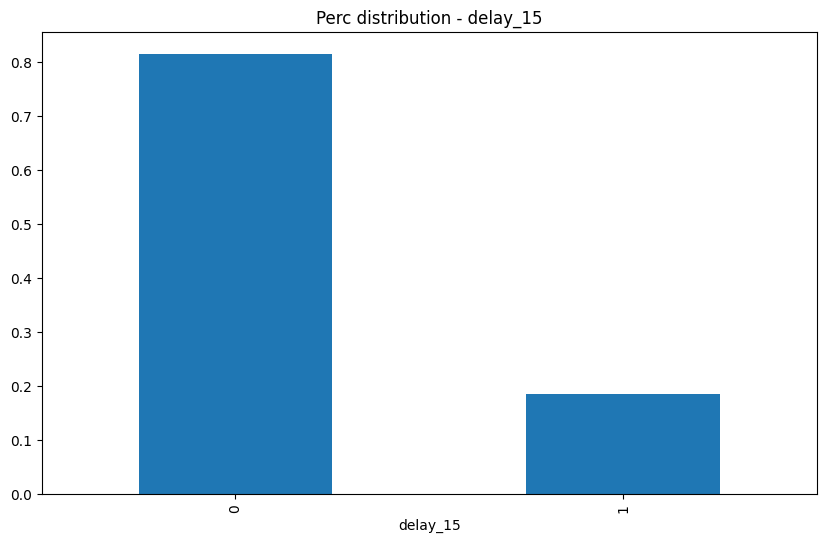

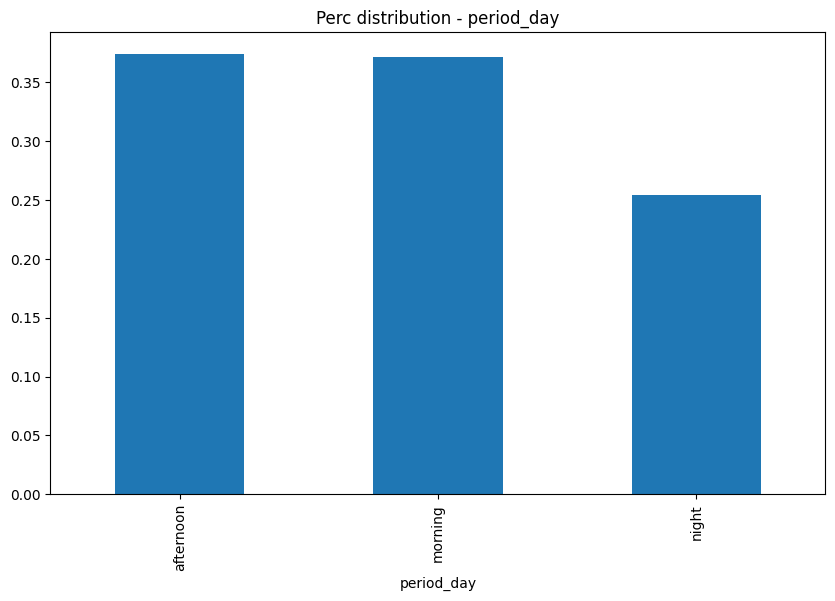

In [28]:

bar_plot_new_features = ['high_season', 'delay_15', 'period_day']
for column_name in bar_plot_new_features:
    plot_bar_categorical_features(df,column_name)

<Axes: >

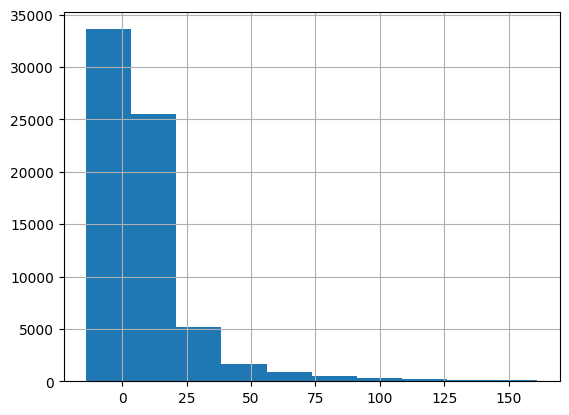

In [29]:
df['min_diff'].hist()

**Insights from new features**
- Long delays are rare; most of the flight delays are around 20 min;
- Most of the time the flight is online or even earlier;
- There are last flights at night;
- The number of flights in the morning and in the afternoon are very similar;
- 20% of the flights delays more than 15 min;
- Around 65% of the flights happens out of high season months.

### 3.3) What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What variables would you expect to have the most influence in predicting delays? <a class="anchor" id="question3"></a>

**Answer:**
- The delay varies significantly according to the airline, month of the year, and destination; It is expected that they will have most influence in the delay prediction;
- There is some in delay according to the weekday;
- There is almost no variation in delay according to the high season; It is expected it will have almost no impact the the delay prediction;
- There is a little variation according to the type of the flight.

In [30]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0,night


In [31]:
def plot_stacked_barplot(x, y):
    # Group the DataFrame by the 'weekdays' column and calculate the percentage of delays (1 or 0) in each group
    grouped_data = df.groupby(y)[x].value_counts(normalize=True).unstack().fillna(0)
    grouped_data['Total Proportion'] = grouped_data[1]
    grouped_data = grouped_data.sort_values('Total Proportion', ascending=False).drop('Total Proportion', axis=1)

    # Plot the grouped bar plot with normalized values
    grouped_data.plot(kind='bar', stacked=True)
    plt.xlabel(y)
    plt.ylabel('Percentage of Delays')
    #plt.figure(figsize=(10,6))
    plt.title('Percentage of Delays (1 or 0) per '+y)
    plt.legend(title='Delay', labels=['No Delay (0)', 'Delay (1)'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().yaxis.set_major_formatter('{:.0%}'.format)  # Format y-axis as percentage
    plt.show()

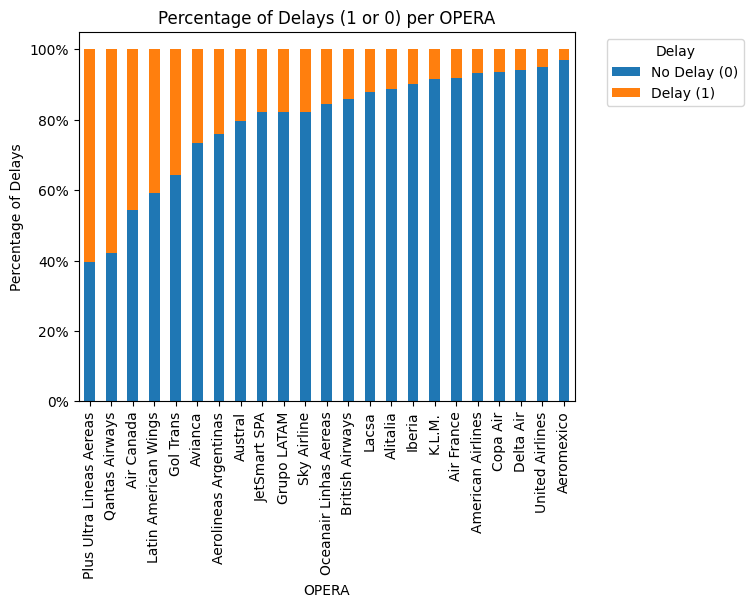

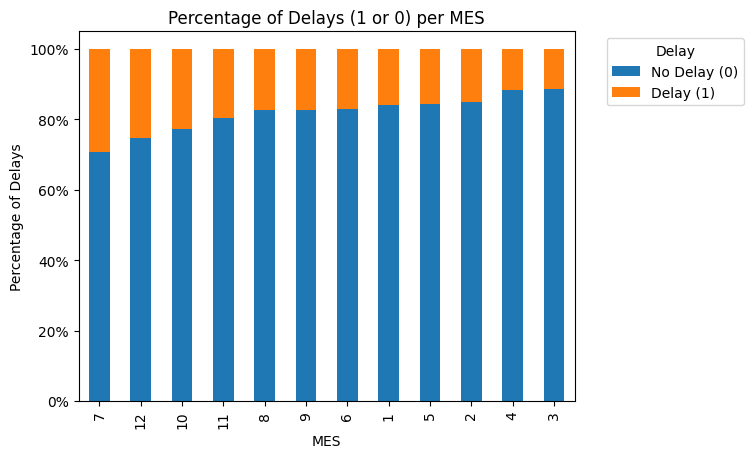

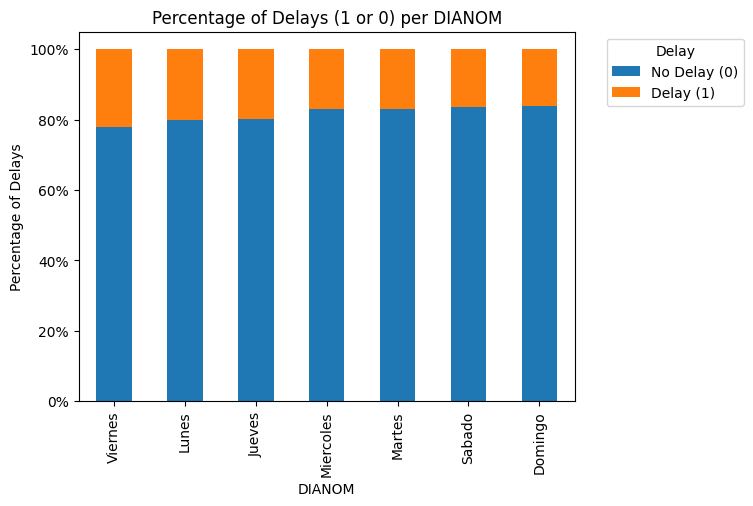

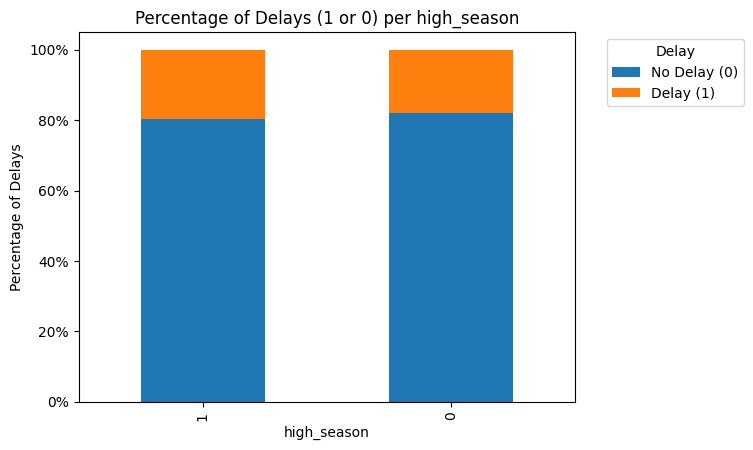

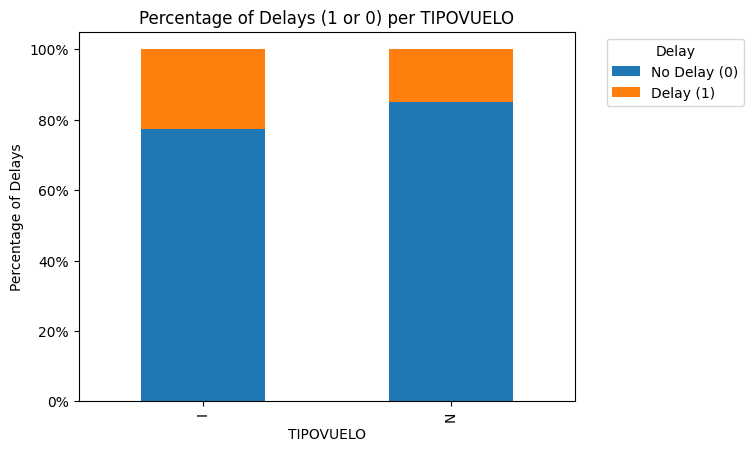

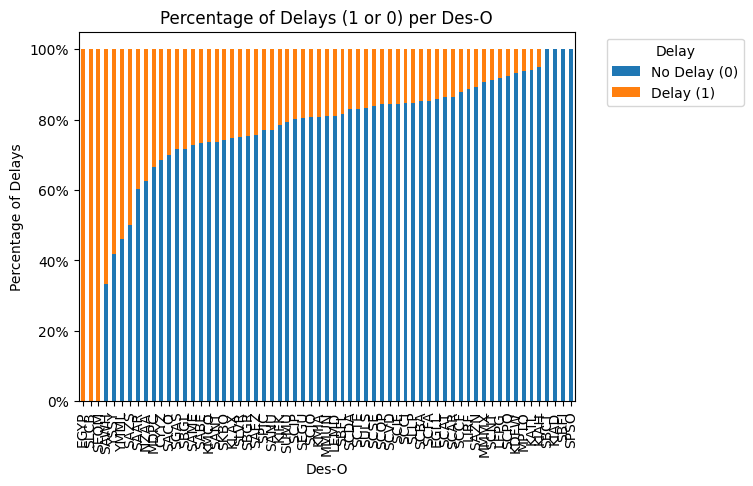

In [32]:
#Plot features with percentage of delays
data_label = 'delay_15'
features_for_analysis = ['OPERA', 'MES', 'DIANOM', 'high_season', 'TIPOVUELO', 'Des-O']
for feature in features_for_analysis:
    plot_stacked_barplot(data_label, feature)

### 3.4) Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay. Feel free to generate additional variables and/or supplement with external variables. <a class="anchor" id="question4"></a>

- The model training and other pre-processing steps were additionally made in topic 3.5

In [33]:
# Dummy code the categorical column
features_to_dummy = ['Des-I', 'Des-O', 'Emp-O', 'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLADES', 'period_day']

# Dummy code the 'Category' column
df_dummies = pd.get_dummies(df, columns=features_to_dummy, drop_first=True, dtype=int)

df_dummies.head()

,Fecha-I,Vlo-I,Ori-I,Emp-I,Fecha-O,Vlo-O,Ori-O,DIA,MES,AÑO,...,SIGLADES_Sao Paulo,SIGLADES_Sydney,SIGLADES_Temuco,SIGLADES_Toronto,SIGLADES_Tucuman,SIGLADES_Ushuia,SIGLADES_Valdivia,SIGLADES_Washington,period_day_morning,period_day_night
0,2017-01-01 23:30:00,226,SCEL,AAL,2017-01-01 23:33:00,226,SCEL,1,1,2017,...,0,0,0,0,0,0,0,0,0,1
1,2017-01-02 23:30:00,226,SCEL,AAL,2017-01-02 23:39:00,226,SCEL,2,1,2017,...,0,0,0,0,0,0,0,0,0,1
2,2017-01-03 23:30:00,226,SCEL,AAL,2017-01-03 23:39:00,226,SCEL,3,1,2017,...,0,0,0,0,0,0,0,0,0,1
3,2017-01-04 23:30:00,226,SCEL,AAL,2017-01-04 23:33:00,226,SCEL,4,1,2017,...,0,0,0,0,0,0,0,0,0,1
4,2017-01-05 23:30:00,226,SCEL,AAL,2017-01-05 23:28:00,226,SCEL,5,1,2017,...,0,0,0,0,0,0,0,0,0,1


In [34]:
df.drop(columns= ['AÑO', 'SIGLAORI', 'Ori-O', 'Ori-I', 'Emp-I', 'Fecha-O', 'Fecha-I', 'delay_15']).head()

,Vlo-I,Des-I,Vlo-O,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,OPERA,SIGLADES,high_season,min_diff,period_day
0,226,KMIA,226,KMIA,AAL,1,1,Domingo,I,American Airlines,Miami,1,3.0,night
1,226,KMIA,226,KMIA,AAL,2,1,Lunes,I,American Airlines,Miami,1,9.0,night
2,226,KMIA,226,KMIA,AAL,3,1,Martes,I,American Airlines,Miami,1,9.0,night
3,226,KMIA,226,KMIA,AAL,4,1,Miercoles,I,American Airlines,Miami,1,3.0,night
4,226,KMIA,226,KMIA,AAL,5,1,Jueves,I,American Airlines,Miami,1,-2.0,night


In [35]:
# Define sets
X = df_dummies.drop(columns= ['AÑO', 'SIGLAORI', 'Ori-O', 'Ori-I', 'Emp-I', 'Fecha-O', 'Fecha-I', 'delay_15'])
y = df_dummies['delay_15']

### 3.5) Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in the prediction task? How could you improve the Performance? <a class="anchor" id="question5"></a>

**Classification metrics**
- Accuracy: It measures how often the classifier correctly predicts. It represents the proportion of correctly classified instances out of the total instances in the dataset. ;
- Precision: Precision explains how many of the correctly predicted cases actually turned out to be positive. It focuses on the correctness of positive predictions. "Of all the instances the model said are positive, how many are actually positive?"
    - Useful to minimize false positive (spam)
- Recall: Recall explains how many of the actual positive cases we were able to predict correctly with our model. "Of all the actual positive instances, how many did the model correctly identify?"
    - Useful to minimize false negative (disease)
- F1:  It gives a combined idea about Precision and Recall metrics, providing a single score. It is the harmonic mean of precision and recall.

[Reference 1](https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/)

[Reference 2](https://chat.openai.com/)

In [54]:
# Define classifiers
classifiers = {
    #'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(silent=True),
    'XGBoost': XGBClassifier(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}

# Define scoring metrics
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Perform k-fold cross-validation and calculate multiple classification metrics
k_folds = 5
results = {}
for clf_name, clf in classifiers.items():
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    scores = cross_validate(clf, X, y, cv=kfold, scoring=scoring)
    results[clf_name] = scores

# Print the results
for clf_name, scores in results.items():
    mean_accuracy = scores['test_accuracy'].mean()
    mean_precision = scores['test_precision_macro'].mean()
    mean_recall = scores['test_recall_macro'].mean()
    mean_f1 = scores['test_f1_macro'].mean()

    print(f"{clf_name}:")
    print(f"  Mean Accuracy = {mean_accuracy:.4f}")
    print(f"  Mean Precision = {mean_precision:.4f}")
    print(f"  Mean Recall = {mean_recall:.4f}")
    print(f"  Mean F1-score = {mean_f1:.4f}")
    print()


/home/jessica/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jessica/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

CatBoost:
  Mean Accuracy = 1.0000
  Mean Precision = 1.0000
  Mean Recall = 1.0000
  Mean F1-score = 1.0000

XGBoost:
  Mean Accuracy = 1.0000
  Mean Precision = 1.0000
  Mean Recall = 1.0000
  Mean F1-score = 1.0000

SVM:
  Mean Accuracy = 0.8598
  Mean Precision = 0.9260
  Mean Recall = 0.6209
  Mean F1-score = 0.6551

Random Forest:
  Mean Accuracy = 1.0000
  Mean Precision = 1.0000
  Mean Recall = 1.0000
  Mean F1-score = 1.0000

Logistic Regression:
  Mean Accuracy = 0.9676
  Mean Precision = 0.9447
  Mean Recall = 0.9484
  Mean F1-score = 0.9465

Naive Bayes:
  Mean Accuracy = 0.6772
  Mean Precision = 0.6274
  Mean Recall = 0.7052
  Mean F1-score = 0.6157

Decision Tree:
  Mean Accuracy = 1.0000
  Mean Precision = 1.0000
  Mean Recall = 1.0000
  Mean F1-score = 1.0000



The models seems to be overfitting. Because the dataset is imbalanced (there is only 20% of delay), I decided to apply SMOTE to balance the dataset and try to solve the overfitting issue.

In [36]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
print("Before applying SMOTE")
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)
print("y.value_counts() = ",y.value_counts())
X, y = oversample.fit_resample(X, y)
print("After applying SMOTE")
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)
print("y.value_counts() = ",y.value_counts())

Before applying SMOTE
X.shape =  (68185, 254)
y.shape =  (68185,)
y.value_counts() =  delay_15
0    55581
1    12604
Name: count, dtype: int64
After applying SMOTE
X.shape =  (111162, 254)
y.shape =  (111162,)
y.value_counts() =  delay_15
0    55581
1    55581
Name: count, dtype: int64


In [60]:
# Define classifiers
classifiers = {
    #'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(silent=True),
    'XGBoost': XGBClassifier(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()
}

# Define scoring metrics
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Perform k-fold cross-validation and calculate multiple classification metrics
k_folds = 5
results = {}
for clf_name, clf in classifiers.items():
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    scores = cross_validate(clf, X, y, cv=kfold, scoring=scoring)
    results[clf_name] = scores

# Print the results
for clf_name, scores in results.items():
    mean_accuracy = scores['test_accuracy'].mean()
    mean_precision = scores['test_precision_macro'].mean()
    mean_recall = scores['test_recall_macro'].mean()
    mean_f1 = scores['test_f1_macro'].mean()

    print(f"{clf_name}:")
    print(f"  Mean Accuracy = {mean_accuracy:.4f}")
    print(f"  Mean Precision = {mean_precision:.4f}")
    print(f"  Mean Recall = {mean_recall:.4f}")
    print(f"  Mean F1-score = {mean_f1:.4f}")
    print()


/home/jessica/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jessica/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

CatBoost:
  Mean Accuracy = 1.0000
  Mean Precision = 1.0000
  Mean Recall = 1.0000
  Mean F1-score = 1.0000

XGBoost:
  Mean Accuracy = 1.0000
  Mean Precision = 1.0000
  Mean Recall = 1.0000
  Mean F1-score = 1.0000

SVM:
  Mean Accuracy = 0.9376
  Mean Precision = 0.9377
  Mean Recall = 0.9376
  Mean F1-score = 0.9376

Random Forest:
  Mean Accuracy = 1.0000
  Mean Precision = 1.0000
  Mean Recall = 1.0000
  Mean F1-score = 1.0000

Logistic Regression:
  Mean Accuracy = 0.9797
  Mean Precision = 0.9799
  Mean Recall = 0.9797
  Mean F1-score = 0.9797

Naive Bayes:
  Mean Accuracy = 0.6760
  Mean Precision = 0.7283
  Mean Recall = 0.6760
  Mean F1-score = 0.6563

Decision Tree:
  Mean Accuracy = 1.0000
  Mean Precision = 1.0000
  Mean Recall = 1.0000
  Mean F1-score = 1.0000



- Without the SMOTE or With the SMOTE, the following models still seems to be overfitting
    - Catboost
    - XGboost
    - Random Forest
    - Decision Tree
- SMOTE improved the performance of the following models:
    - SVM
    - Logistic regression
- SMOTE improved the accuracy and recall score and made worse the precision and F1 score of the following model:
    - Naive Bayes
- The rank of the best models with SMOTE were
    - Logistc regression (1st place)
    - SVM (2nd place)
    - Naive Bayes (3rd place)

Now, it is interesting to double check if the best model (Logistic regression) is not overfitting. Let's check that bellow:

In [37]:
X.reset_index(inplace=True)

/tmp/ipykernel_2534/1975192971.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.reset_index(inplace=True)


In [38]:
# Define the classifier
clf = LogisticRegression()

# Perform k-fold cross-validation and calculate metrics
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

f1_scores_train = []
f1_scores_val = []
accuracy_scores_train = []
accuracy_scores_val = []
precision_scores_train = []
precision_scores_val = []
recall_scores_train = []
recall_scores_val = []

print("X.shape = " ,X.shape)
print("y.shape = " ,y.shape)
print("type(X) = ", type(X))
print("type(y) = ", type(y))


for train_index, val_index in kf.split(X):
    #print("train_index = ", train_index)
    #print("val_index = ", val_index)
    #X_train, X_val = X[train_index], X[val_index]
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions on training and validation sets
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)

    # Calculate metrics for training set
    f1_train = f1_score(y_train, y_train_pred, average='macro')
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred, average='macro')
    recall_train = recall_score(y_train, y_train_pred, average='macro')

    # Calculate metrics for validation set
    f1_val = f1_score(y_val, y_val_pred, average='macro')
    accuracy_val = accuracy_score(y_val, y_val_pred)
    precision_val = precision_score(y_val, y_val_pred, average='macro')
    recall_val = recall_score(y_val, y_val_pred, average='macro')

    # Append scores to lists
    f1_scores_train.append(f1_train)
    f1_scores_val.append(f1_val)
    accuracy_scores_train.append(accuracy_train)
    accuracy_scores_val.append(accuracy_val)
    precision_scores_train.append(precision_train)
    precision_scores_val.append(precision_val)
    recall_scores_train.append(recall_train)
    recall_scores_val.append(recall_val)

# Calculate mean scores for training and validation sets
mean_f1_train = np.mean(f1_scores_train)
mean_f1_val = np.mean(f1_scores_val)
mean_accuracy_train = np.mean(accuracy_scores_train)
mean_accuracy_val = np.mean(accuracy_scores_val)
mean_precision_train = np.mean(precision_scores_train)
mean_precision_val = np.mean(precision_scores_val)
mean_recall_train = np.mean(recall_scores_train)
mean_recall_val = np.mean(recall_scores_val)

# Print the results
print("Mean F1-score (Training):", mean_f1_train)
print("Mean F1-score (Validation):", mean_f1_val)
print("Mean Accuracy (Training):", mean_accuracy_train)
print("Mean Accuracy (Validation):", mean_accuracy_val)
print("Mean Precision (Training):", mean_precision_train)
print("Mean Precision (Validation):", mean_precision_val)
print("Mean Recall (Training):", mean_recall_train)
print("Mean Recall (Validation):", mean_recall_val)


X.shape =  (111162, 255)
y.shape =  (111162,)
type(X) =  <class 'pandas.core.frame.DataFrame'>
type(y) =  <class 'pandas.core.series.Series'>


/home/jessica/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jessica/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Mean F1-score (Training): 0.9503325136939159
Mean F1-score (Validation): 0.9507200891716675
Mean Accuracy (Training): 0.9503495175430559
Mean Accuracy (Validation): 0.9507384599919201
Mean Precision (Training): 0.950881310557558
Mean Precision (Validation): 0.9512699354683244
Mean Recall (Training): 0.9503507383295278
Mean Recall (Validation): 0.9507337257095385


- The model does not seem to be overfitting because the performance of the training set and validation set are very similar. I could do a deeper check for all the other models but due to time restriction I will stick to the Logistic regression model.

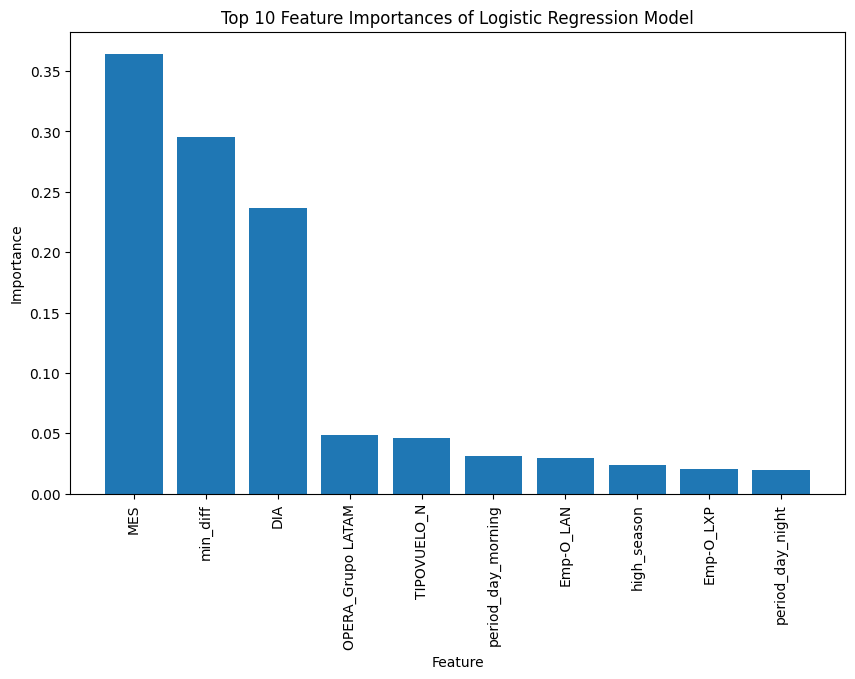

In [41]:
feature_importance = abs(clf.coef_[0])

# Create a DataFrame to store feature importance and their corresponding feature names
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 10 features
top_10_features = feature_importance_df.head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_10_features['Feature'], top_10_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances of Logistic Regression Model')
plt.show()

- Above we have the top 10 features that have the most impact in the model classification. For more details we could use shap beeswarm plot to deeper the analysis.
- The features that most impact the model were not necessary all the same expected by the EDA. It might be due to the dimensionality of the data.
- To improve the model's performance we could do:
    - Feature selection, to select the features that provides the most information to the model;
    - Dimensionality reduction;
    - Tune the model's hyperparamenter;
    - Do more feature engineering with the existing features;
    - Check the possibility to acquire more data as: weather information, number of passangers, distance traveled, etc.